In [84]:
%run srcnn.py

In [64]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%matplotlib inline
from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2

import pywt

K.tensorflow_backend.set_session(tf.Session(config=config))

In [65]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

session = tf.Session(config=config)
keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5946362398750201279
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9008283648
locality {
  bus_id: 1
}
incarnation: 15934353208765760410
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 186515456
locality {
  bus_id: 2
}
incarnation: 8609414312838599751
physical_device_desc: "device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:83:00.0, compute capability: 5.2"
]
['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1']


### Load images

In [66]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]

In [67]:
#Display images
def print_luminance(img, ch=1) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')

In [68]:
PATH = ""
TRAIN_FILE = PATH + "datasets/DIV2K_train_HR/"
obj_files = listdir(TRAIN_FILE )

In [69]:
len(obj_files)

496

In [70]:
#Load images

obj_img = []
train_img = []
valid_hr_img = []
valid_lr_img= []

for i in range(0,90):
    n = obj_files[i]
    obj_img.append(Image.open(TRAIN_FILE + n))
    
#Only consider the luminance channel (YCrCb)
ycbcr = convertToYCbCr(obj_img)

In [71]:
#Convert images to numpy array
hd = [np.asarray(image)[:,:,0] for image in ycbcr]

(2040, 1356)


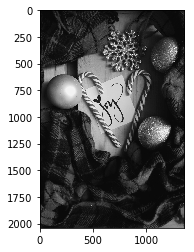

In [72]:
print(hd[0].shape)
plt.imshow(hd[0], 'gray')

### Generate train and test set

In [73]:
def getSubImage(img, height, width, centerX, centerY, len_interval, scale = 1) :
    window = window_size // scale
    return img[ height   : height//2 + window + centerX*len_interval,
                width // 2  + centerY*len_interval : width//2 + window + centerY*len_interval : ]

In [74]:
def retSize(x):
    return (x.shape[0], x.shape[1])

In [75]:
#Division by 4
window_size= 64
scale = 4
stride = 30

In [76]:
def getSubImages(image, stride = stride) :
    sub = []
    height, width = utility.getSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

In [77]:
p = hd[i][:10, :10]

height, width = utility.getSize(p)
print(width)

10


In [78]:
bicubic = utility.bicubicInterpolation(p, 1/4., (height,width))

In [85]:
img_len = 90

sub_labels = []
sub_samples = []

for i in range(0,img_len) :
    label, sample = get_input_images(hd[i], 4.)
    
    #Calculate subimages
    sub_labels += getSubImages(label)
    sub_samples += getSubImages(sample)

sub_samples = [sub_sample / 255. for sub_sample in sub_samples]
sub_labels = [sub_labels / 255. for sub_labels in sub_labels]

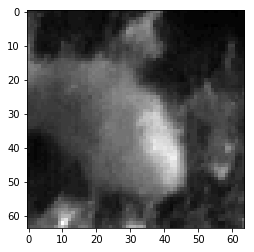

In [86]:
plt.imshow(sub_labels[10], 'gray')

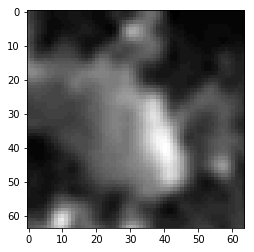

In [87]:
plt.imshow(sub_samples[10], 'gray')

#### Generate the wavelets subbands

In [88]:
def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

In [89]:
def plot4images(im1, im2, im3, im4, ch=1) :
    size = (10, 10)
    fig = plt.figure(figsize=size)
    
    plt.subplot(221)
    plt.title("Approximation")
    print_luminance(im1, ch )
    plt.subplot(222)
    plt.title("Horizontal")
    print_luminance(im2, ch)
    plt.subplot(223)
    plt.title("Vertical")
    print_luminance(im3, ch)
    
    plt.subplot(224)
    plt.title("Diagonal")
    print_luminance(im4, ch)

def plot_waveletTrans(wt, ch=1) :
    plot4images(wt[0], wt[1][0], wt[1][1], wt[1][2], ch)

In [91]:
x_sample = sub_samples[20]
x_dwt = pywt.dwt2(x_sample, 'haar')
x_dwt[0].shape

(32, 32)

(32, 32)


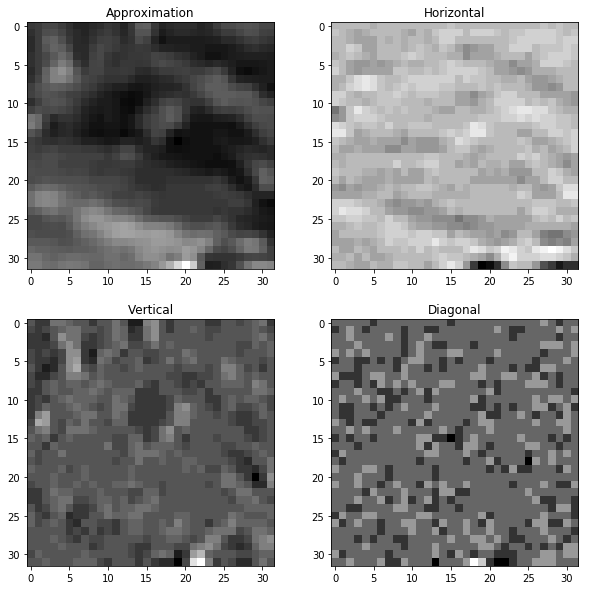

In [92]:
x_sample = sub_samples[20]
x_dwt = pywt.dwt2(x_sample, 'haar')
print(x_dwt[0].shape)
plot_waveletTrans(x_dwt)

In [108]:
def get_wavelets(labels, samples) :
    
    label_set = [] 
    train_set = []
    for i in range(len(labels)) :
        x = samples[i]
        y = labels[i]
    
    
        dwt_y = pywt.dwt2(y, 'haar')
        dwt_x = pywt.dwt2(x, 'haar')    
    
    
        dwt_hd = np.asfarray([dwt_y[0], dwt_y[1][0], dwt_y[1][1], dwt_y[1][2]])
        
        dwt_lw = np.asfarray([dwt_x[0], dwt_x[1][0], dwt_x[1][1], dwt_x[1][2]])    
        label = dwt_hd - dwt_lw
        
        label_set.append(label)
        train_set.append(dwt_lw)
    
    index = np.random.permutation(len(label_set))
    
    label_set = np.asarray(label_set)
    train_set = np.asarray(train_set)
    
    return label_set[index], train_set[index]

In [109]:
def get_channels(img) :
    return img[:,:,0], img[:,:,1], img[:,:,2]

In [110]:
test, train = get_wavelets(sub_labels, sub_samples)

In [111]:
train.shape

(263736, 4, 32, 32)

In [112]:
test.shape

(263736, 4, 32, 32)

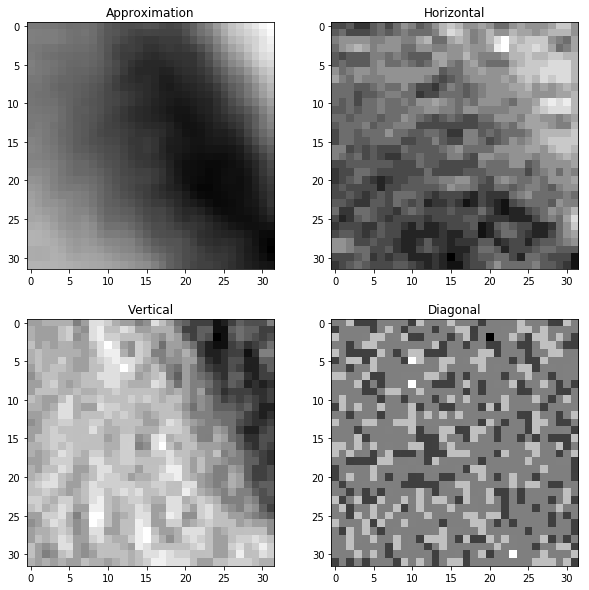

In [113]:
sample = train[20]
plot4images(sample[0], sample[1], sample[2], sample[3])

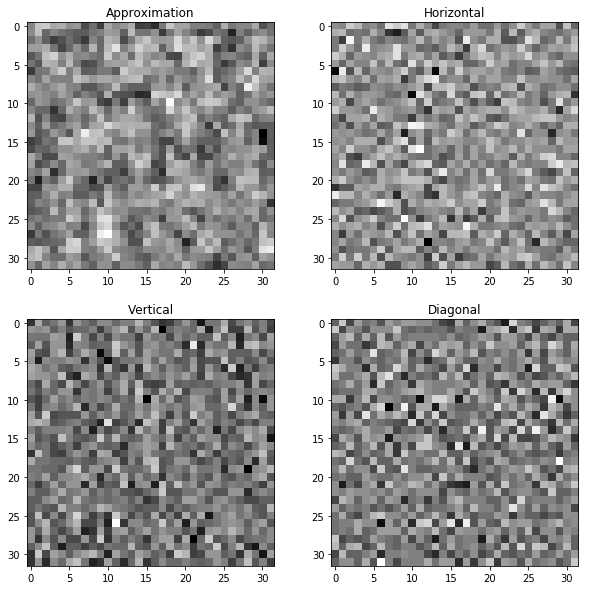

In [114]:
label = test[20]
plot4images(label[0], label[1], label[2], label[3])

#### Creating and Training the networks

In [115]:
def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

In [117]:
input_shape = train.shape
shape_ = (input_shape[1],input_shape[2], input_shape[3])
shape_

(4, 32, 32)

In [118]:
kernel_ini = initializers.RandomNormal(mean=0.0, stddev=1e-3)
bias_ini = keras.initializers.Zeros()

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) 

In [119]:
def wavelet_mode () :
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(5,5),strides=(1,1),padding='same',
                 activation='relu',
                 input_shape=shape_,
                 kernel_initializer=initializers.RandomNormal(stddev=np.sqrt(2.0/9)),
                 bias_initializer=bias_ini,
                 data_format='channels_first'))
    for i in range(10) :
        model.add(Conv2D(64,
                     kernel_size=(3, 3),
                     strides=(1,1), 
                     activation='relu', 
                     padding='same', 
                     kernel_initializer=initializers.RandomNormal(stddev=np.sqrt(2.0/9/64)),
                     bias_initializer=bias_ini, data_format='channels_first'))

    
    model.add(Conv2D(4, 
                 kernel_size=(3, 3),
                 strides=(1,1), 
                 padding='same', 
                 kernel_initializer=initializers.RandomNormal(stddev=np.sqrt(2.0/9/64)),
                 bias_initializer=bias_ini, data_format='channels_first'))

    model.compile(optimizer=optimizers.Adam(),
             loss='mse')

    return model

In [120]:
def fit_model(model, train, test) :
    model.fit(train, test, validation_split=0.20, epochs=50, batch_size=64, verbose=1)

In [121]:
model = wavelet_mode()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 32, 32)        6464      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 32, 32)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 32, 32)        36928     
__________

In [ ]:
red_model = wavelet_mode()
fit_model(red_model, train, test)

In [ ]:
save_model(ycbcr_model, "SRCNN_ycbcr_channel")

In [35]:
ycbcr_model = load_model("SRCNN_ycbcr_channel")

#### Original image and bicubic interpolated image

In [131]:
def patchs_to_image(patches, height, width, strides=stride) :
    count = 0
    window_size = 64
    
    img = np.zeros((height, width, 3), dtype='uint8')
    
    for h in range(0, height - window_size, strides) :
        for w in range (0, width - window_size, strides) : 
            img[h : h + window_size, w : w + window_size] = patches[count]
            count = count + 1
        
    assert(len(patches) == count)
    return img

In [14]:
valid_folder = "datasets/SR_Test/Set5/"

In [15]:
valid = listdir(valid_folder)
index = 3

In [113]:
im = Image.open(valid_folder + "/" + valid[index])
ycbcr = convertToYCbCr(im)

img = np.asarray(ycbcr)

org, bic = get_input_images(img, 4)

h, w = utility.getSize(org)
org.shape

(256, 256, 3)

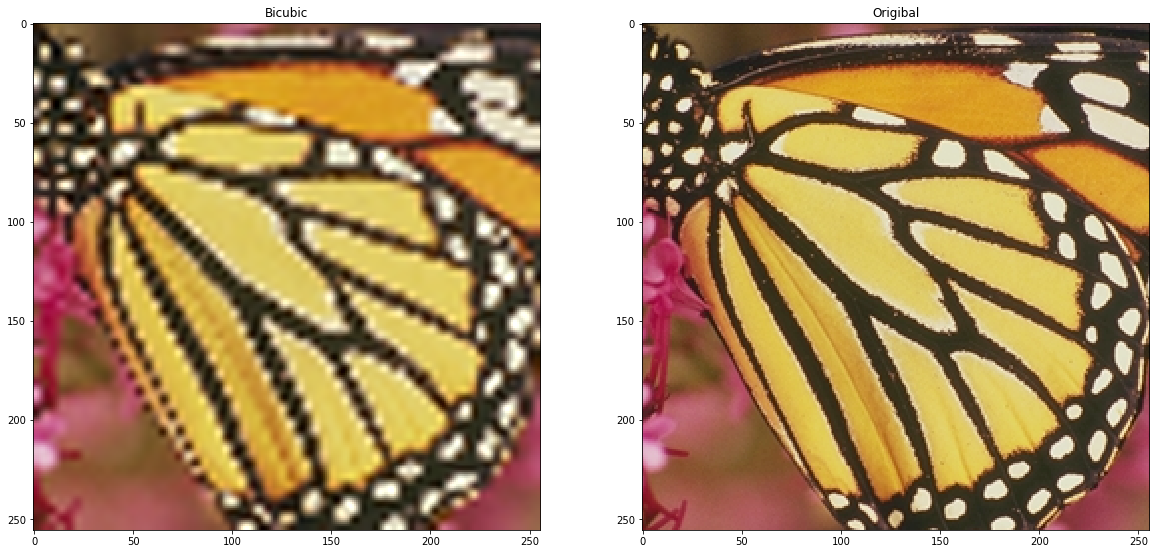

In [19]:
plot_images([org, bic], ["Origibal", "Bicubic"], size=(20, 10), ch=3)

In [211]:
stride = 10
sub_img = getSubImages(bic, stride)
sub_img = [img.astype(float) / 255. for img in sub_img]
sub_img[0].shape

(64, 64, 3)

In [212]:
def get_wavelets(img) :
    
    dwt = pywt.dwt2(img, 'haar')
    
    dwt = np.asfarray([dwt[0], dwt[1][0], dwt[1][1], dwt[1][2]])
        
    return dwt

In [213]:
wavelets = np.zeros((len(sub_img), 4, 32, 32))

for i in range(len(sub_img)) :
    red_wavelets[i] = get_wavelets(sub_img[i])

In [214]:
wavelets.shape

(400, 4, 32, 32)

In [215]:
pred_wave = ycbcr_model.predict(wavelets)

In [216]:
def iwavelet(patch, max_value=255) :
    dwt = (patch[0], (patch[1], patch[2], patch[3]))
    inverse = pywt.idwt2(dwt, 'haar')
    return np.clip(inverse, 0, inverse.max())

In [217]:
hd_wave = wavelets + pred_wave

#sub_imgs = np.zeros((len(red), window_size, window_size, 3))
for i in range(len(hd_wave)) :    
    sub_imgs[i] = iwavelet(hd_wave[i])*255.

sub_imgs = sub_imgs.astype('uint8')

In [218]:
sub_imgs.shape

(400, 64, 64, 3)

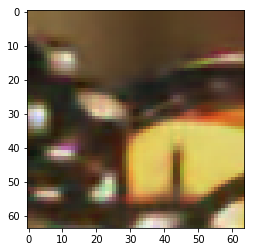

In [219]:
plt.imshow(sub_imgs[1])

In [220]:
im = patchs_to_image(sub_imgs, h, w, stride)

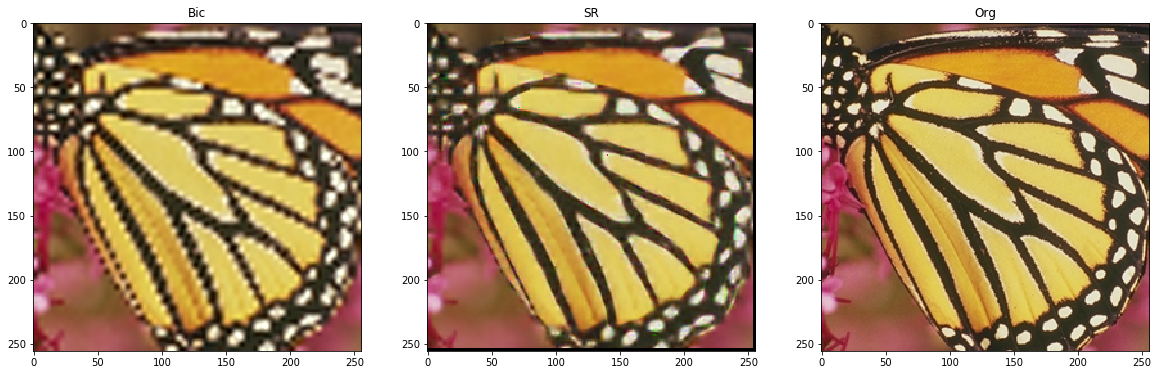

In [221]:
plot_images ([org, bic, im], ["Org", "Bic", "SR"], size= (20,20)) 

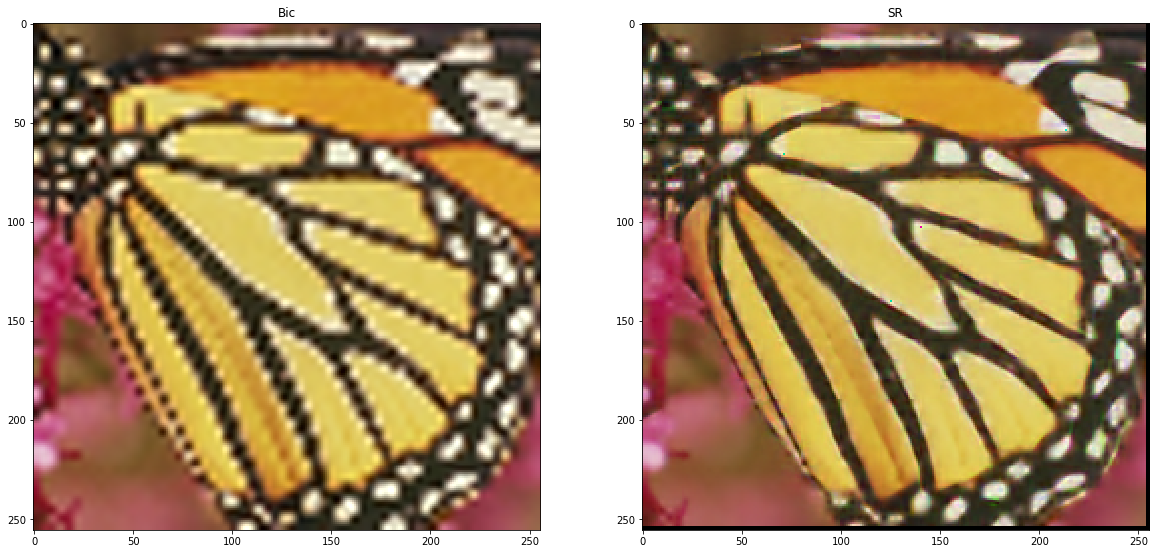

In [222]:
plot_images ([im, bic], ["SR", "Bic"], size= (20,20), ch=3) 